# VAE

##V2

In [1]:
import tensorflow as tf
tf.random.set_seed(1)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
import numpy as np

dataset = np.concatenate([x_train, x_test], axis=0)
dataset = np.expand_dims(dataset, -1).astype("float32") / 255

In [4]:
BATCH_SIZE = 64

dataset = np.reshape(dataset, (-1, 28, 28, 1))
# Converte o array numpy para um objeto tensorflow
dataset = tf.data.Dataset.from_tensor_slices(dataset)
# Embara o dataset e divide em lotes para evitar vicios de aprendizado no modelo
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [5]:
x_test.shape

(10000, 28, 28)

In [6]:
from tensorflow import keras
from tensorflow.keras import layers


# Create a sampling layer
class SamplingLayer(layers.Layer):
  """Reparameterization Trick z = mu + sigma * epsilon"""

  def call(self, inputs):
    zMean, zLogVar = inputs # Média e variância
    batch = tf.shape(zMean)[0] # Número de amostras
    dim = tf.shape(zMean)[1] # Numero de features por amostra
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # tensor de ruido seguindo a distribuição gaussiana
    return zMean + tf.exp(0.5 * zLogVar) * epsilon

In [7]:
from tensorflow import keras
from tensorflow.keras import layers


# Create a sampling layer
class SamplingLayer(layers.Layer):
  """Reparameterization Trick z = mu + sigma * epsilon"""

  def call(self, inputs):
    zMean, zLogVar = inputs # Média e variância
    batch = tf.shape(zMean)[0] # Número de amostras
    dim = tf.shape(zMean)[1] # Numero de features por amostra
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # tensor de ruido seguindo a distribuição gaussiana
    return zMean + tf.exp(0.5 * zLogVar) * epsilon

In [8]:
def buildEncoder(latentDim, encoderInputs):

  # Given a batch of images the convolutional block extracts the features
  l1 = keras.models.Sequential([
    layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2D(64, 3, activation="relu", strides=2, padding="same"),
    layers.Flatten(),
    layers.Dense(256, activation="relu")
  ])

  # pass the inputs through the convolutional block
  x = l1(encoderInputs)

  # a dedicated layer to learn mean in parallel
  zMean = layers.Dense(latentDim, name="z_mean")(x)

  # a dedicated layer to learn variance in parallel
  zLogVar = layers.Dense(latentDim, name="z_log_var")(x)

  # now the reparametrization trick to find z as defined by mean and variance
  z = SamplingLayer()([zMean, zLogVar])

  # the actual model which takes the images as input and returns mean, variance, and distribution
  # please note the zMean and zLogVar are not the final output of the encoder, but
  # they are used in the Kullback-Leibler Divergence Loss (explained below)
  return keras.Model(encoderInputs, [zMean, zLogVar, z], name="encoder")


# trigger the function to actually build the model
encoderInputs = keras.Input(shape=(28, 28, 1))
encoder = buildEncoder(2, encoderInputs)
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 256)       │    878,144 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        514 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        514 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_layer      │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (SamplingLayer)     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 879,172 (3.35 MB)

 Trainable params: 879,172 (3.35 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
def buildDecoder(latentInputs):

  l1 = keras.models.Sequential([
    layers.Dense(7*7*64, activation="relu", input_shape=(latentInputs.shape[1],)),
    layers.Reshape((7,7,64)),
    layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")
  ])

  return keras.Model(latentInputs, l1(latentInputs), name="decoder")

# build the actual model
latentInputs = keras.Input(shape=(2,))
decoder = buildDecoder(latentInputs)
decoder.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 28, 28, 1)      │       157,633 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,633 (615.75 KB)

 Trainable params: 157,633 (615.75 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
def reconstructionLoss(data, reconstructed):
  return tf.reduce_mean(
      tf.reduce_sum(
          keras.losses.binary_crossentropy(data, reconstructed),
          axis=(1, 2)
      )
  )

In [11]:
def klDivergenceLoss(zMean, zLogVar):
  return tf.reduce_mean(
      tf.reduce_sum(
          -0.5 * (1 + zLogVar - tf.square(zMean) - tf.exp(zLogVar)),
          axis=1
      )
  )

In [12]:
def calcTotalLoss(data, reconstructed, zMean, zLogVar):
  loss1 = reconstructionLoss(data, reconstructed)
  loss2 = klDivergenceLoss(zMean, zLogVar)
  klWeight = 3.0
  return  loss1, loss2, loss1 + klWeight * loss2

In [13]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    # register total loss as an observable metric in the model training history
    self.totalLossTracker = keras.metrics.Mean(name="total_loss")
    self.ceLossTracker = keras.metrics.Mean(name="ce_loss")
    self.klLossTracker = keras.metrics.Mean(name="kl_loss")

  # This are all observable metrics
  @property
  def metrics(self):
    return [
        self.totalLossTracker,
        self.ceLossTracker,
        self.klLossTracker
    ]

  # Now calculate loss + calculate gradients + update weights
  def train_step(self, data):
    # Gradient tape is a recording of all gradients for the trainable
    # weights that need to be updated
    with tf.GradientTape() as tape:
        # forward path
        zMean, zLogVar, z = self.encoder(data)
        reconstruction = self.decoder(z)
        ceLoss, klLoss, totalLoss = calcTotalLoss(data, reconstruction, zMean, zLogVar)
    # backward path
    grads = tape.gradient(totalLoss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    # keep track of loss
    self.totalLossTracker.update_state(totalLoss)
    self.ceLossTracker.update_state(ceLoss)
    self.klLossTracker.update_state(klLoss)

    # return the loss for history object
    return {
        "total_loss": self.totalLossTracker.result(),
        "ce_loss": self.ceLossTracker.result(),
        "kl_loss": self.klLossTracker.result()
    }

In [14]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
history = vae.fit(dataset, epochs=32, batch_size=128)

Epoch 1/32
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - ce_loss: 214.7410 - kl_loss: 1.8002 - total_loss: 220.1417
Epoch 2/32
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - ce_loss: 156.3740 - kl_loss: 3.9344 - total_loss: 168.1771
Epoch 3/32
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - ce_loss: 150.5586 - kl_loss: 4.3743 - total_loss: 163.6813
Epoch 4/32
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - ce_loss: 147.4205 - kl_loss: 4.5715 - total_loss: 161.1349
Epoch 5/32
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - ce_loss: 145.4529 - kl_loss: 4.7144 - total_loss: 159.5962
Epoch 6/32
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - ce_loss: 144.1091 - kl_loss: 4.8180 - total_loss: 158.5632
Epoch 7/32
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - ce_loss: 142.9165 - kl_loss: 4.8824 - total_loss: 157.5638
Epoch 8/32
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - ce_loss: 142.1173 - kl_loss: 4.9404 - total_loss: 156.9384
Epoch 9/32
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - ce_loss: 141.3468 -

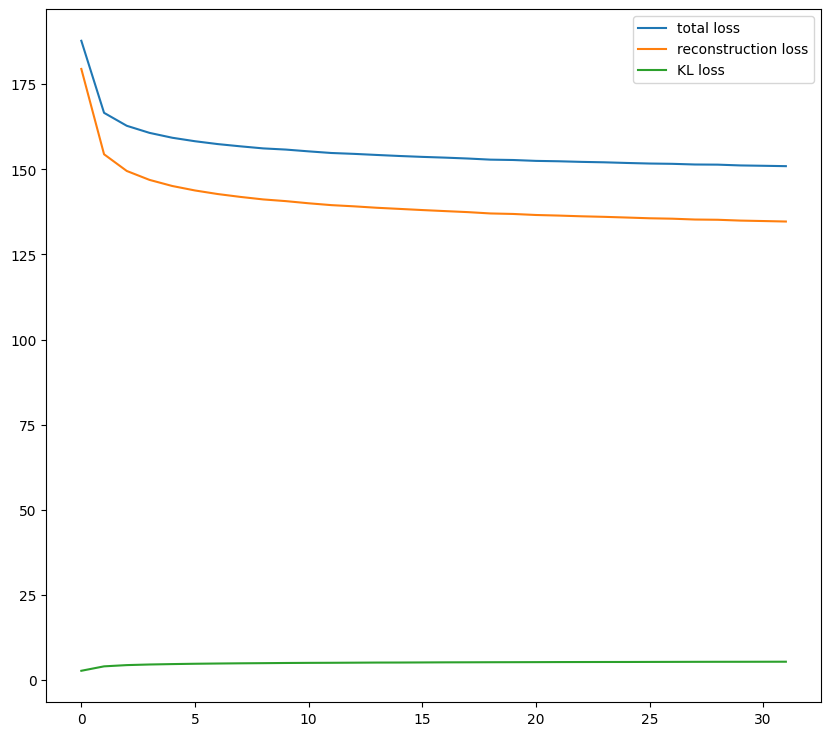

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 9))
plt.plot(history.history.get('total_loss'), label="total loss")
plt.plot(history.history.get('ce_loss'), label="reconstruction loss")
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

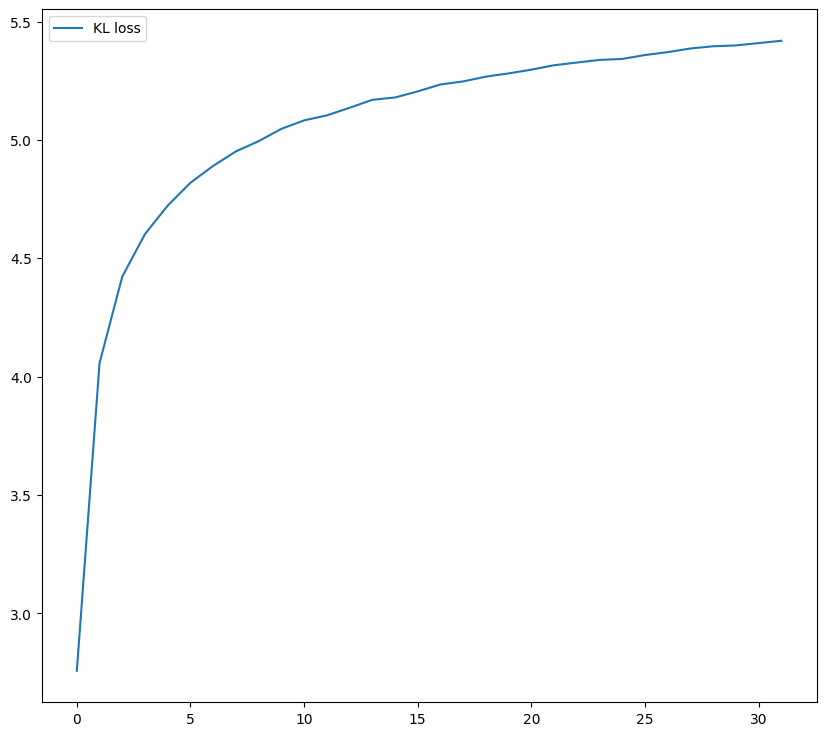

In [18]:
plt.figure(figsize=(10, 9))
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


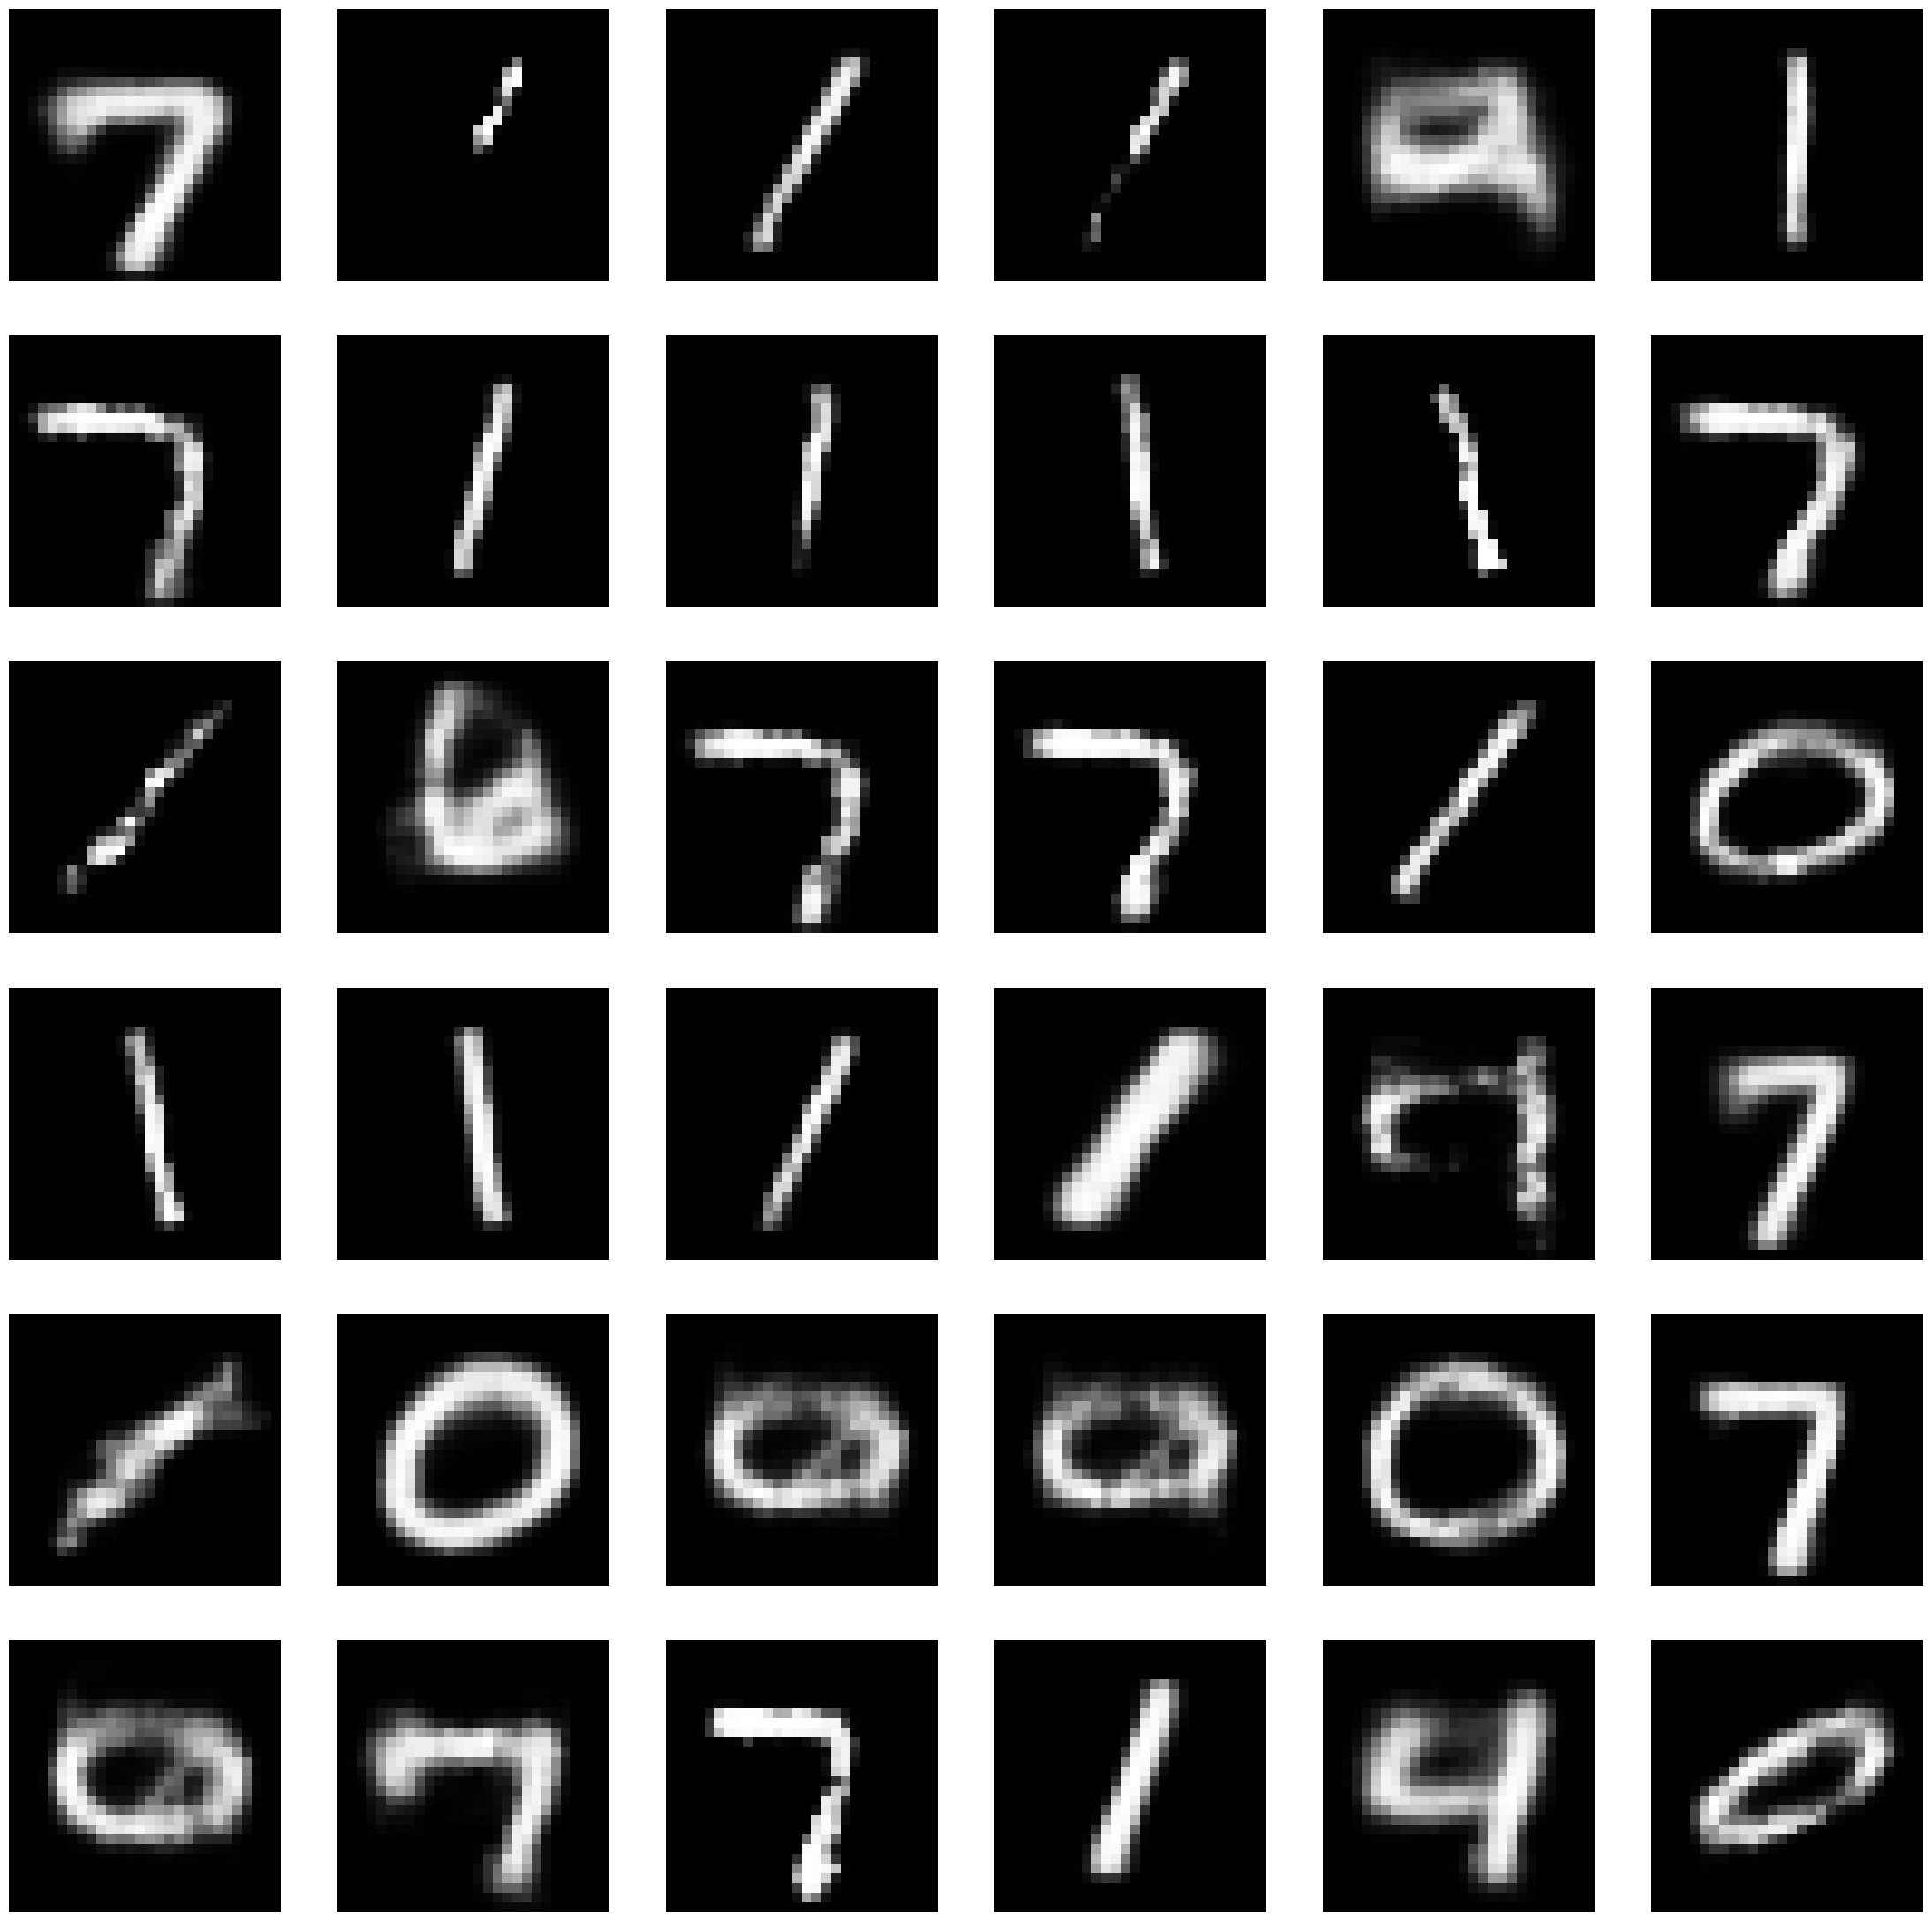

In [20]:
z = np.random.normal(loc=0, scale=4, size=(256,2))
synth = vae.decoder.predict(z)

plt.figure(figsize=(28,28))

for i in range(36):
    plt.subplot(6,6,i+1)
    plt.imshow(synth[i].reshape((28,28)), cmap="Greys_r")
    plt.axis('off')

plt.show();